<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 1 - Importer les données et explorer les radiographies</span>

Le zip "**mri_dataset_brain_cancer_oc**" contient deux dossiers et un fichier texte qui résume le contenu du dataset:
- **sans_label/**: 1406 images non étiquetées
- **avec_labels/**: 100 images étiquetées

Dans le dossier avec label on trouve deux sous-dossiers:
- **Normal/** : 50 images de cerveaux sains.
- **Cancer/** : 50 images de cerveaux présentant des signes de tumeurs.

**Caractéristiques des images**

- Toutes les images ont été redimensionnées à une taille standardisée de 512×512 pixels. 
- Elles sont enregistrées au format d'image courant JPEG (.jpg).
- Poids moyen autour de 20 Ko
- Nomination hashé
- Noir et blanc
- Qualité des images variable (floue, saturée ...)
- Coupes variables (dessus, de face, de profil) avec prédominance des coupes du dessus (ou dessous?)
- Certaines images ont des cadres, des echelles, des caractéristiques d'imagerie (W,L, n°)

<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 2 - Pré-traitement et extraction des features</span>

Comme nous l'avions relevé, les images nécéssitent un pré traitement afin de pouvoir être utilisable. Elles ont la même structure externe (pixels, format, poids, nomination) mais leur contenu doit aussi être standardiser:
- normaliser la nuance de gris
- enlever les informations d'image dans les images (W,L,n°) ($\approx$ data leaking)
Une fois celà fait, il restera à transformer les images en données exploitable à savoir l'embedding visuel via ResNet.

In [76]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import gc

# On utilise pytorch ici plutot que tensorflow
# Avantage: plus personnalisable VS Plus facile a utiliser 
# Définit les tenseurs, couches de neurones et algo d'opti (SGD,Adam)
import torch
import torch.nn as nn
import torch.optim as optim
# Pour créer une structure pour lire les images et les envoyer par paquet (batches) au GPU
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split



In [78]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [79]:
# Ajoute le dossier datas_manipulation au sys.path. Remarque ne pas oublier le __init__.py dans le dossier datas_manipulation
import sys
# root_path = Path(__file__).resolve().parents[1] # Ne fonctionne pas sur notebook
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))

In [80]:
# Fonctions personnelles

from utils.dataset import BaseTransform, ImagesToDataset
from utils.models import FeatureExtractor, BrainTumorClassifier
from utils.analysis import ClusterManager
from utils.training import Trainer
from utils.plotting.make_model_plots import plot_clustering


In [81]:

# Variables/paramètres globales

# Création dossier results
SAVE_PATH = ROOT_PATH.joinpath('datas/results')
Path.mkdir(SAVE_PATH,exist_ok = True)

# Pour la reproductibilité (similaire a random_state) 
# --> influence l'initialisation des poids ResNet et le mélange du DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Config pour basculer sur le GPU si possible (50x plus rapide en deep learning que CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
# Taille des paquets (en puissance de 2 pour s'aligner avec l'archi GPU: 2 4 8 16 32 64)
BATCH_SIZE = 16

# Config des images
IMG_SIZE = 224 # Résolution standard 
# Cas transfer learning avec ResNet: Les valeurs données sont les moyennes et ecarts type des 
# couleurs RGB dans ImageNet
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

RANDOM_STATE=42
N_JOBS=-1
N_FEATURES = 512 # Nombre de features issu des CNN,en 18,34 couches on a 512 features, 
# en 50,101 et 152 on passe a 2048 features, avec VGG16 on est 4096 
# et pour EfficientNet-BO c'est 1280 features

Running on: cpu


<span style="color:blue;font-size:1.2em;font-weight:bold">Préparation et embedding</span>

<span style="color:orange;font-weight:bold"> *Remarque personnelle*: Il est interessant de s'appercevoir que Pytorch pousse à travailler au travers de subclass</span>

In [82]:
# Chemin des données brutes
DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# Listing des fichiers qui composent les labellisés des non labellisés
# glob pour les fichiers et rglob si il y a des sous-dossiers
avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))

# Encodage des labels (0: normal, 1: cancer, -1: sans_label)
avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
all_paths = avec_labels_path + sans_label_path
all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))

del avec_labels_path, sans_label_path, avec_labels_encoding
gc.collect()

29087

<span style="color:purple;font-weight:bold">Extraction des features via ResNet</span>

Comme toujours, il est nécéssaire d'avoir des informations compréhensibles pour une machine pour qu'un modèle puisse performer (ce n'est donc pas le cas des images). Pour cela on va donc pré-traiter les images afin qu'elles partent d'une base commune (redimensionnement et normalisation).

On va ensuite utiliser un CNN (ResNet18 par exemple) auquel on retire la dernière couche (couche de classification) afin d'obtenir un extracteur de features et on fait passer toutes les images pour constituer un tableau dont les lignes représentent les images et les colonnes, les caractéristiques de ces images.

In [83]:
# Traitement des images
# Instanciation du pré traitement
transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE).preproc(train=False)
# Génration du dataset SANS les augmentations (train et test encore mélangé pour le moment)
full_dataset = ImagesToDataset(all_paths, all_labels, transform=transform)
# Génération du loader qui va fournir la donnée au GPU par batch
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instanciation du modèle d'extraction des caractéristiques
# to(DEVICE) déplace les poids du modèle de la RAM/CPU vers la VRAM/GPU
extractor = FeatureExtractor(pretrained=True).to(DEVICE)
# Rend le comportement de certaines couches déterministes ==> indispensable pour l'embedding
extractor.eval()

# Extraction
features_list = []
labels_list = []

# Par défaut, Pytorch mémorise chaque calcul pour faire la retropropagation de gradient
# indispensable si entrainement or ici on souhaite juste lire, on desactive donc la mémoire.
with torch.no_grad():
    for images, labels, _ in full_loader:
        images = images.to(DEVICE)
        features = extractor(images) # (Batch, N_FEATURES)
        features_list.extend(features.cpu().numpy()) # GPU --> CPU + tenseurs --> tableau numpy
        labels_list.extend(labels.cpu().tolist())

# Mise sous forme de df
cols = [f"feature_{i}" for i in range(N_FEATURES)]
df_features = pd.DataFrame(features_list, columns=cols)
df_features['label'] = labels_list

In [ ]:
df_features.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,label
0,0.000711,0.967595,0.341529,1.901165,0.957052,3.594041,1.203337,0.389920,0.420447,0.136591,...,0.397860,0.141049,0.005128,0.185610,0.775661,0.677914,0.303889,1.273226,0.953451,1
1,0.424082,0.343133,1.549181,3.534758,1.059536,1.690318,0.384711,0.404190,0.012817,1.010008,...,0.086452,0.576635,0.133820,0.174625,0.355586,0.689909,1.641374,1.027018,2.266930,1
2,0.675654,2.226976,0.932349,5.832372,1.212539,0.576981,0.037122,0.586905,0.789708,0.367418,...,0.394682,0.671208,0.159386,0.336243,0.265793,3.298335,0.623389,0.689923,0.839203,1
3,0.492489,1.867785,0.566270,3.990413,0.600058,0.658403,0.139563,0.024514,0.573939,0.230976,...,0.449933,0.919753,0.273202,1.060444,0.089835,1.702788,0.648243,1.465206,0.565843,1
4,0.112004,0.384682,1.264945,2.737785,0.332712,2.672765,0.376925,0.833677,0.213646,0.729568,...,0.218833,0.278125,0.545321,0.000000,1.831624,0.803235,0.703025,0.836682,1.709315,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0.006405,0.136414,1.512641,0.941664,1.664566,2.969823,0.007459,1.768473,0.007002,0.158311,...,0.221768,0.039385,0.000000,0.000000,1.347690,1.755577,1.163037,0.751532,2.214543,-1
1502,0.715534,0.369962,0.317774,4.504199,1.907490,2.126535,0.331211,1.628019,0.276294,0.563095,...,0.910072,0.794032,0.608267,0.000000,1.378763,0.010411,1.044090,1.296727,2.305586,-1
1503,0.008715,1.170317,0.744825,3.400005,0.809380,1.125671,0.000000,2.032016,0.028869,0.234772,...,1.188077,0.117312,0.390858,0.000000,0.727583,0.778228,0.691374,0.000000,1.367548,-1
1504,0.557858,4.596770,1.459527,2.872154,0.239375,1.521812,0.066270,0.304337,1.347005,0.238630,...,0.864958,0.752212,0.101672,0.631959,0.642704,0.721948,0.044677,1.591138,1.639508,-1


<span style="color:red">ajouter save df, tester differents ResNet? quest ce que le CNN?</span>

On a un df avec les 100 premiers elements les fortements labellisés: les 50 premiers sont les cancereux, les 50 suivants les sains et les 1406 après les inconnus

<span style="color:purple;font-weight:bold">Clustering et visualisation</span>

Le but à cete étape est de confirmer que le CNN amputé employé est capable de caractériser correctement les images.

Pour cela on va on test le tableau de features obtenu, on utilise pour cela un reducteur de dimension et un cluster.
1. Le modèle de réduction de dimension va condenser l'information issu de l'ensemble des features en n_components qui vont servir de coordonnées spatiale.
    - Le PCA est une méthode linéaire qui cherche à faire pivoter les données pour trouver les axes de plus grande variance.
    - Le t-SNE est non-linéaire et cherche à conserver la structure locale (les voisins proches).
2. Le modèle de clustering va procéder au regroupement des images en cluster (groupe/classe...) en cohérance avec les informations des images.
    - KMeans divise l'espace en "cellules" autour de centres (centroïdes).
    - DBSCAN regarde si les points sont "serrés".

A la fin de ce process, on juge suivant l'ARI qui va valider la qualité des embeddings:
- Si le CNN (ResNet18 par exemple) est bon, les features extraites devraient avoir formé des lignes (caract des images) dont les tenseurs sont similaires suivant qui soient d'une classe ou de l'autre (sain/cancer).
- Si le clustering (KMeans ou DBSCAN) a regroupé correctement les images (score ARI -> 1) alors l'extraction de feature est validée, l'extracteur est utilisable

In [ ]:
# Dictionnaires des hyperparamètres des modèles
# Réduction de dimension
pca_dict = {
    "n_components": 10, # Nombre de dimensions finales. 
    # rq: si entre 0 et 1, on demande une proportion d'information a conserver
}
tsne_dict= {
    "n_components": 2, 
    "random_state": RANDOM_STATE, 
    "init": 'pca', #Comment placer les points au départ. 'pca' est plus stable que 'random'
    "learning_rate": 'auto',
    "n_jobs":N_JOBS
}

# Clustering
kmeans_dict = {
    "n_clusters": 2, #Le nombre de groupes imposé.
    "random_state": RANDOM_STATE, 
    "n_init": 10,
    # init : "k-means++", # Placement intelligent, Centroides loin les uns des autres au départ.
    # max_iter: 300,
}
dbscan_dict = {
    "eps": 2.0, # Distance max pour que deux points == "voisins". Très sensible. défaut 0.5
    "min_samples": 5, # Nb min de points pour former un groupe. Si <5, tout devient un cluster
    # metric : "euclidean", # Regle de calcul des distance
    # algorithm : "auto", # Méthode de recherche des voisins
    # leaf_size : 30, # lié a algorithm "ball_tree". Impacte la vitesse
    "n_jobs" : N_JOBS
}

In [113]:

# Instanciation du Manager
analyzer = ClusterManager(df_features)

# Réduction et clustering des features
reduction_dim = analyzer.reduce_dimensions(
    pca_params = pca_dict,
    tsne_params = tsne_dict
) # PCA & t-SNE
df_cluster = analyzer.apply_clustering(
    kmeans_params = kmeans_dict,
    dbscan_params = dbscan_dict
) # K-Means & DBSCAN

# Score
ari_score_kmeans = analyzer.evaluate_ari(method='cluster_kmeans')
ari_score_dbscan = analyzer.evaluate_ari(method='cluster_dbscan')
print(f"ARI (ONLY true_labels) :\nKMeans: {ari_score_kmeans:.4f}\nDBSCAN: {ari_score_dbscan:.4f}")
print("Interprétation : ARI -> 1 == clustering a parfaitement retrouvé les classes Normal/Cancer.")

# # Visualisation
# analyzer.plot_results()

ARI (ONLY true_labels) :
KMeans: -0.0051
DBSCAN: 0.0379
Interprétation : ARI -> 1 == clustering a parfaitement retrouvé les classes Normal/Cancer.


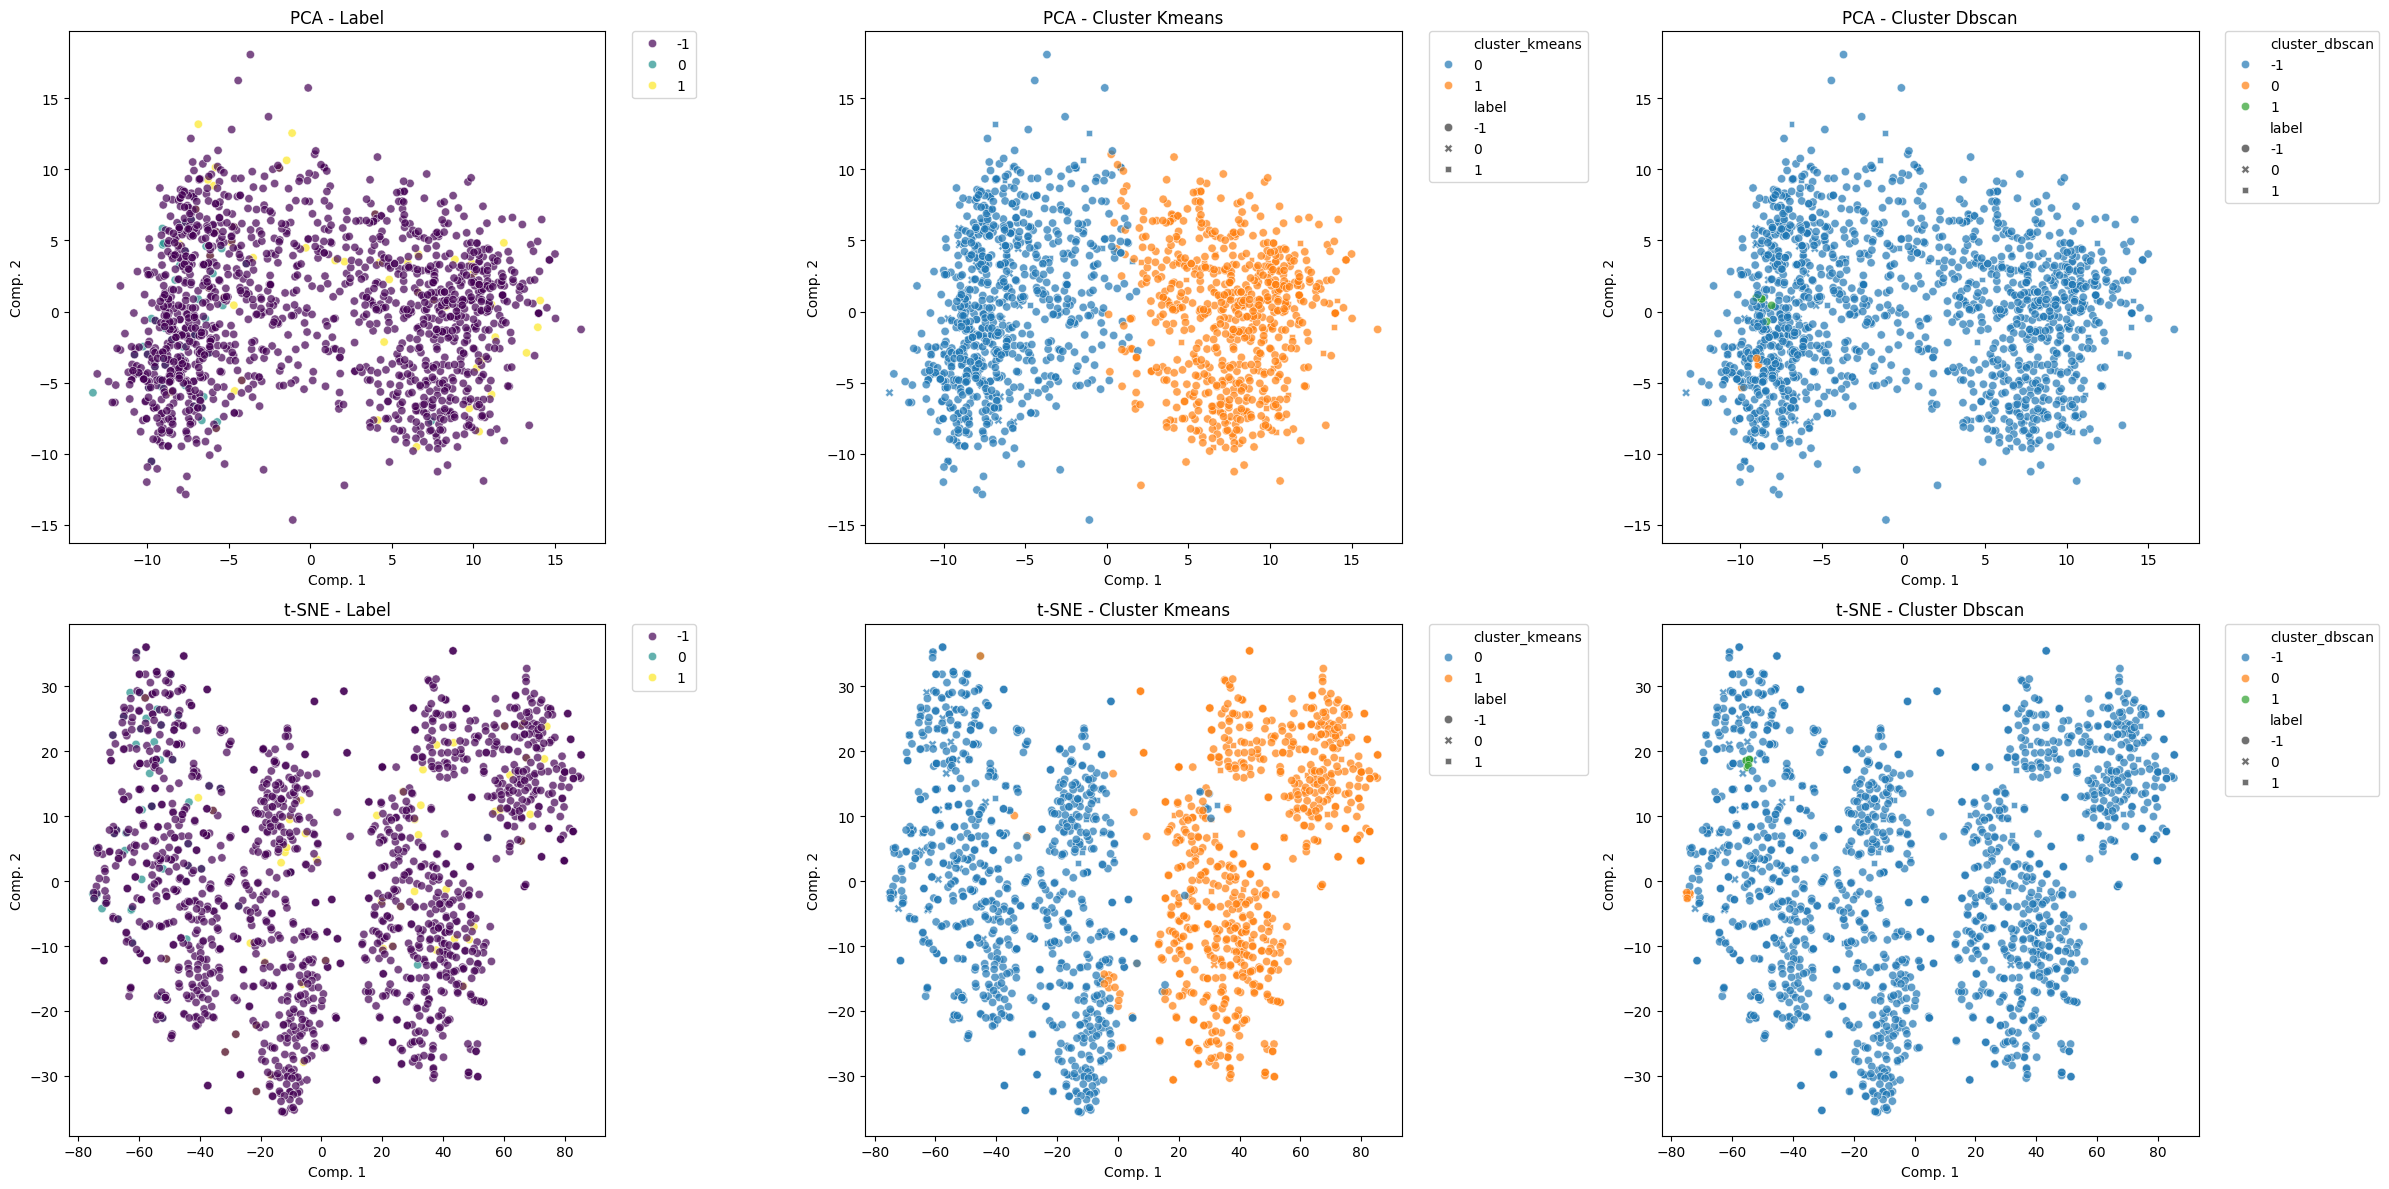

In [114]:
# Visualisation

fig_cluster = plot_clustering(df_cluster, reduction_dim)